In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Third-party
from astropy.utils.console import ProgressBar
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as pl
import numpy as np
pl.style.use('ggplot')
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import scipy.optimize as so
import emcee

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import rotation_matrix_helper as rmh
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
import streamframe as sf
from gala.coordinates import reflex_correct
import streamsample as ss

In [4]:
# Galactocentric reference frame to use for this project
galactocentric_frame = coord.Galactocentric(z_sun=0.*u.pc,
                                            galcen_distance=8.3*u.kpc)
vcirc = 238.*u.km/u.s
vlsr = [-11.1, 12.24, 7.25]*u.km/u.s

galcen_frame = dict()
galcen_frame['galactocentric_frame'] = galactocentric_frame
galcen_frame['vcirc'] = vcirc
galcen_frame['vlsr'] = vlsr

In [5]:
true_potential = gp.HernquistPotential(m=5E11, c=20., units=galactic)

/anaconda3/lib/python3.6/site-packages/astro_gala-0.4.dev2256-py3.6-macosx-10.7-x86_64.egg/gala/integrate/timespec.py:38: UserWarning: The argument 'nsteps' is deprecated and will be removed in a future version.Use 'n_steps' instead.
  warn("The argument 'nsteps' is deprecated and will be removed in a future version."


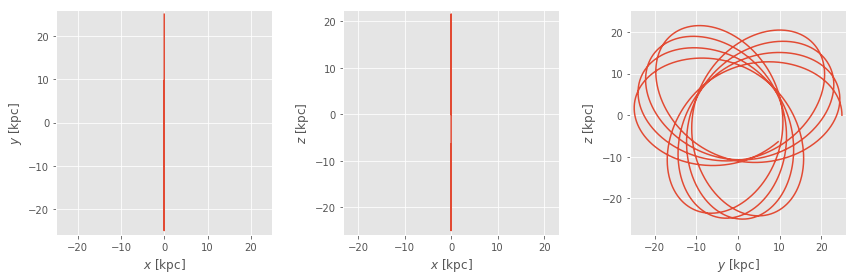

In [6]:
w0 = gd.CartesianPhaseSpacePosition(pos=[0,25.,0]*u.kpc,
                                    vel=[0,0,100]*u.km/u.s)
prog_orbit = true_potential.integrate_orbit(w0, dt=1., nsteps=5500, 
                                            Integrator=gi.DOPRI853Integrator)
fig = prog_orbit.plot()


In [7]:
stream = mockstream.fardal_stream(true_potential, prog_orbit=prog_orbit, 
                                  prog_mass=5E5*u.Msun, release_every=1, Integrator=gi.DOPRI853Integrator)

Text(0,0.5,'Z [kpc]')

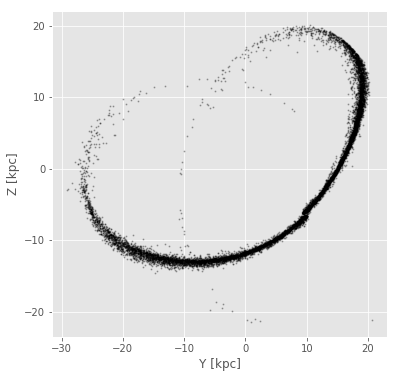

In [8]:
fig,ax = pl.subplots(1,1,figsize=(6,6))
ax.plot(stream.pos.y.value, stream.pos.z.value, 'ko', alpha=0.25, markersize=1)
ax.set_xlabel('Y [kpc]')
ax.set_ylabel('Z [kpc]')

In [9]:
prog_g = prog_orbit.to_coord_frame(coord.Galactic, **galcen_frame)
stream_g = stream.to_coord_frame(coord.Galactic, **galcen_frame)

Text(0,0.5,'b')

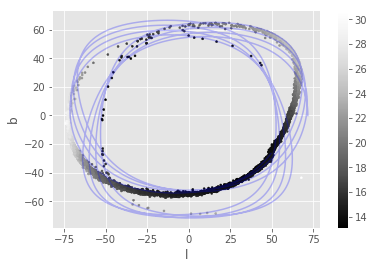

In [10]:
pl.plot(prog_g.l.wrap_at(180*u.deg).degree, prog_g.b.degree, marker=None, alpha=0.25, color='b')
pl.scatter(stream_g.l.wrap_at(180*u.deg).degree, stream_g.b.degree, 
           c=stream_g.distance.value, cmap='Greys_r', s=4)
pl.colorbar()
pl.xlabel('l')
pl.ylabel('b')

In [102]:
np.random.seed(12)
idx = np.random.permutation(np.arange(len(stream_g)-2000, len(stream_g), dtype=int))[:64]
obs_c = stream_g[idx]

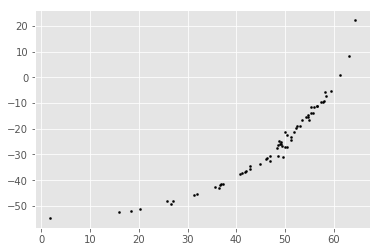

In [104]:
pl.scatter(obs_c.l.wrap_at(180*u.deg).degree, obs_c.b.degree, s=4, c='k')

In [105]:
R = rmh.compute_stream_rotation_matrix(obs_c.transform_to(coord.ICRS), zero_pt=prog_g[-1].transform_to(coord.ICRS))
ModelStream = sf.StreamFrame(M=R)

In [106]:
print(R)

[[ 0.69135299 -0.72218944  0.02175913]
 [-0.38932286 -0.34699163  0.85324353]
 [-0.60865323 -0.59836379 -0.52105856]]


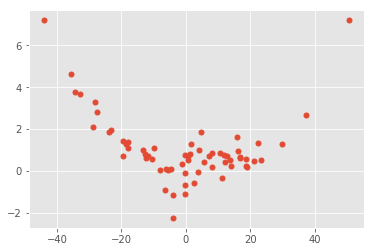

In [107]:
# rotate all data to plot
rot_rep = obs_c.transform_to(ModelStream)

pl.figure()
pl.plot(rot_rep.phi1.wrap_at(180*u.deg).degree, rot_rep.phi2.degree, ls='none', marker='o', ms=5.)

## Prepare data for MCMC sampling

In [108]:
n_data = len(obs_c)
data = dict()
err = dict()

# err['distance'] = 0.02*obs_c.distance
# err['mul'] = 0.1*u.mas/u.yr
# err['mub'] = 0.1*u.mas/u.yr
# err['vr'] = 10.*u.km/u.s
err['distance'] = 1E-6*obs_c.distance
err['mul'] = 1E-1*u.mas/u.yr
err['mub'] = 1E-1*u.mas/u.yr
err['vr'] = 1E-6*u.km/u.s

data['phi1'] = rot_rep.phi1
data['phi2'] = rot_rep.phi2
data['l'] = obs_c.l
data['b'] = obs_c.b
data['distance'] = obs_c.distance  + np.random.normal(0., err['distance'].value, size=n_data)*obs_c.distance.unit
data['mul'] = obs_c.pm_l_cosb      + np.random.normal(0., err['mul'].value,      size=n_data)*err['mul'].unit
data['mub'] = obs_c.pm_b           + np.random.normal(0., err['mub'].value,      size=n_data)*err['mub'].unit
data['vr'] = obs_c.radial_velocity + np.random.normal(0., err['vr'].value,       size=n_data)*err['vr'].unit

In [112]:
freeze = dict()
# these estimated from the plots
freeze['phi2_sigma'] = np.radians(0.9)
freeze['d_sigma'] = 0.15
freeze['vr_sigma'] = (1.5*u.km/u.s).decompose(galactic).value 
freeze['t_forw'] = 100.
freeze['t_back'] = -100.
# freeze['hernquist_logm'] = np.log10(true_potential.parameters['m'].value)

index = data['phi1'].argmin()
p0_guess = [data['phi2'].radian[index],
            data['distance'].decompose(galactic).value[index],
            data['mul'].decompose(galactic).value[index],
            data['mub'].decompose(galactic).value[index],
            data['vr'].decompose(galactic).value[index],
            np.log10(true_potential.parameters['m'].value)]

In [113]:
def plot_mcmc_sample_orbit(p):
    #take mcmc parameters and generated x, y, z, vx, vy, vz
    w0 = ss._mcmc_sample_to_w0(p, R)
    
    #take values of x, y, z, vx, vy, vz and calculate an orbit
    orbit = ss.integrate_forward_backward(potential, w0, t_back=freeze['t_back'], t_forw=freeze['t_forw'])
    #orbit = true_potential.integrate_orbit(w0, dt=-0.5, t1=0., t2=freeze['t_back'])
    orbit_c = orbit.to_coord_frame(coord.Galactic, **galcen_frame)

    #plot comparison of observed stream to orbit 
    fig,axes = pl.subplots(2,2,figsize=(12,8), sharex=True)

    # l,d
    axes[1,0].errorbar(obs_c.l.wrap_at(180*u.deg).degree, data['distance'].value, err['distance'].value,
                       ls='none', marker='.', ecolor='#aaaaaa')
    l, = axes[1,0].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.distance.value, marker=None)
    col = l.get_color()
    axes[1,0].set_xlabel('l'); axes[1,0].set_ylabel('distance')

    # l,b
    axes[0,0].scatter(obs_c.l.wrap_at(180*u.deg).degree, obs_c.b.degree, marker='.', c='k')
    axes[0,0].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.b.degree, marker=None, c=col)
    axes[0,0].set_xlabel('l'); axes[0,0].set_ylabel('b')
    
    # l,mul
    axes[0,1].errorbar(obs_c.l.wrap_at(180*u.deg).degree, data['mul'].value, err['mul'].value,
                       ls='none', marker='.', ecolor='#aaaaaa')
    #axes[0,1].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.pm_l_cosb.value, marker=None, c=col)
    axes[0,1].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.pm_l_cosb.value, marker=None, c=col)

    axes[0, 1].set_xlabel('l'); axes[0, 1].set_ylabel('pm_l')
    
    # l,mub
    axes[1,1].errorbar(obs_c.l.wrap_at(180*u.deg).degree, data['mub'].value, err['mub'].value,
                       ls='none', marker='.', ecolor='#aaaaaa')
    #axes[1,1].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.pm_b.value, marker=None, c=col)
    axes[1,1].plot(orbit_c.l.wrap_at(180*u.deg).degree, orbit_c.pm_b.value, marker=None, c=col)

    axes[1, 1].set_xlabel('l'); axes[1,1].set_ylabel('pm_b')

    fig.tight_layout()
    return fig,axes


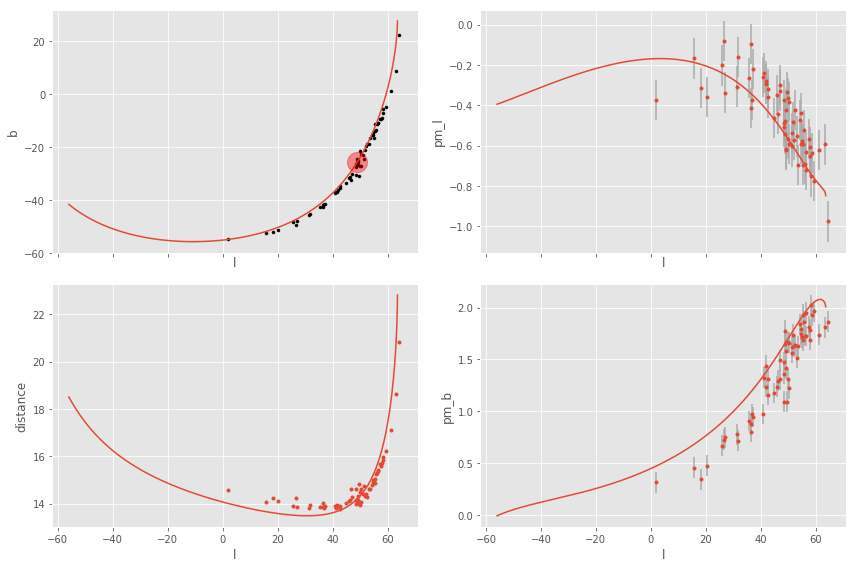

In [114]:
potential = gp.HernquistPotential(m=true_potential.parameters['m'].value, c=true_potential.parameters['c'], units=galactic)

fig,axes = plot_mcmc_sample_orbit(p0_guess)

derp = sf.StreamFrame(phi1=data['phi1'][index][None],
                      phi2=data['phi2'][index][None],
                      distance=data['distance'][index][None], M=R)
g = derp.transform_to(coord.Galactic)
axes[0,0].plot(g.l.degree, g.b.degree, marker='o', color='r', alpha=0.4, markersize=20)

In [115]:
o1 = potential.integrate_orbit(w0, dt=-0.5, t1=0.0, t2=-150, Integrator=gi.DOPRI853Integrator)

In [116]:
print(ss.ln_likelihood(p0_guess, data, err, R, gp.HernquistPotential, true_potential, 0.5, freeze).sum())
print(ss.ln_prior(p0_guess, data, err, R, gp.HernquistPotential, true_potential, 0.5, freeze))
print(ss.ln_posterior(p0_guess, data, err, R, gp.HernquistPotential, true_potential, 0.5, freeze))


-1885818.63936
2.93622886079
-1885815.70313


In [117]:
labels = ['phi2','d','mul','mub','vr','t_forw','t_back','phi2_sigma','d_sigma','vr_sigma','hernquist_logm']
values = ss._unpack(p0_guess, freeze)

In [118]:
for l, v in zip(labels, values): print('{0:15}'.format(l), v)

phi2            0.0121352548409
d               14.1665907911
mul             -0.00262968427352
mub             0.00799656694206
vr              -0.108695764067
t_forw          100.0
t_back          -100.0
phi2_sigma      0.0157079632679
d_sigma         0.15
vr_sigma        0.0015340682475805615
hernquist_logm  11.6989700043


In [ ]:
args = (data, err, R, gp.HernquistPotential, true_potential, 0.5, freeze)
#print(len(*args)) #, **kwargs)
res = so.minimize(lambda *args : -ss.ln_posterior(*args),
                  x0=p0_guess, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})

#ptions={'func': None, 'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': None, 'maxfev': None, 'disp': False, 'direc': None, 'return_all': False}

In [ ]:
fig, axes  = plot_mcmc_sample_orbit(res.x)

In [27]:
n_walkers = 2*len(p0_guess)
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, dim=len(p0_guess), lnpostfn=ss.ln_posterior,
                                args=args)

mcmc_p0 = emcee.utils.sample_ball(p0_guess, 1E-3*np.array(p0_guess), size=n_walkers)


In [28]:
n_iterations = 256

with ProgressBar(n_iterations, ipython_widget=True) as bar:
    for results in sampler.sample(mcmc_p0, None, None, iterations=n_iterations):
        bar.update()
        
# _ = sampler.run_mcmc(mcmc_p0, N=128)


A Jupyter Widget

In [29]:
sampler.chain.shape

(12, 256, 6)

In [30]:
sampler.chain[...,0].shape

(12, 256)

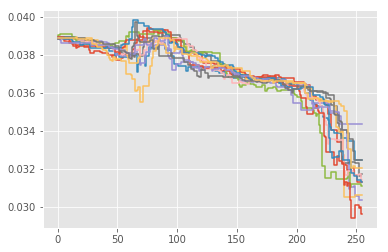

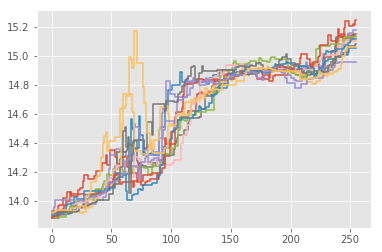

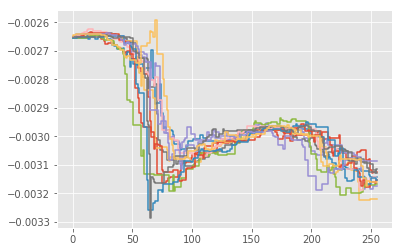

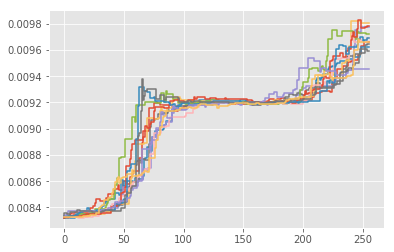

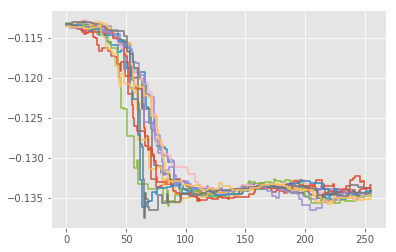

In [31]:
for i in range(5):
    pl.figure()
    for walker in sampler.chain[:,:,i]:
        pl.plot(walker, marker=None, drawstyle='steps')

In [38]:
samples = sampler.chain[:, 250:, :].reshape((-1, len(p0_guess)))

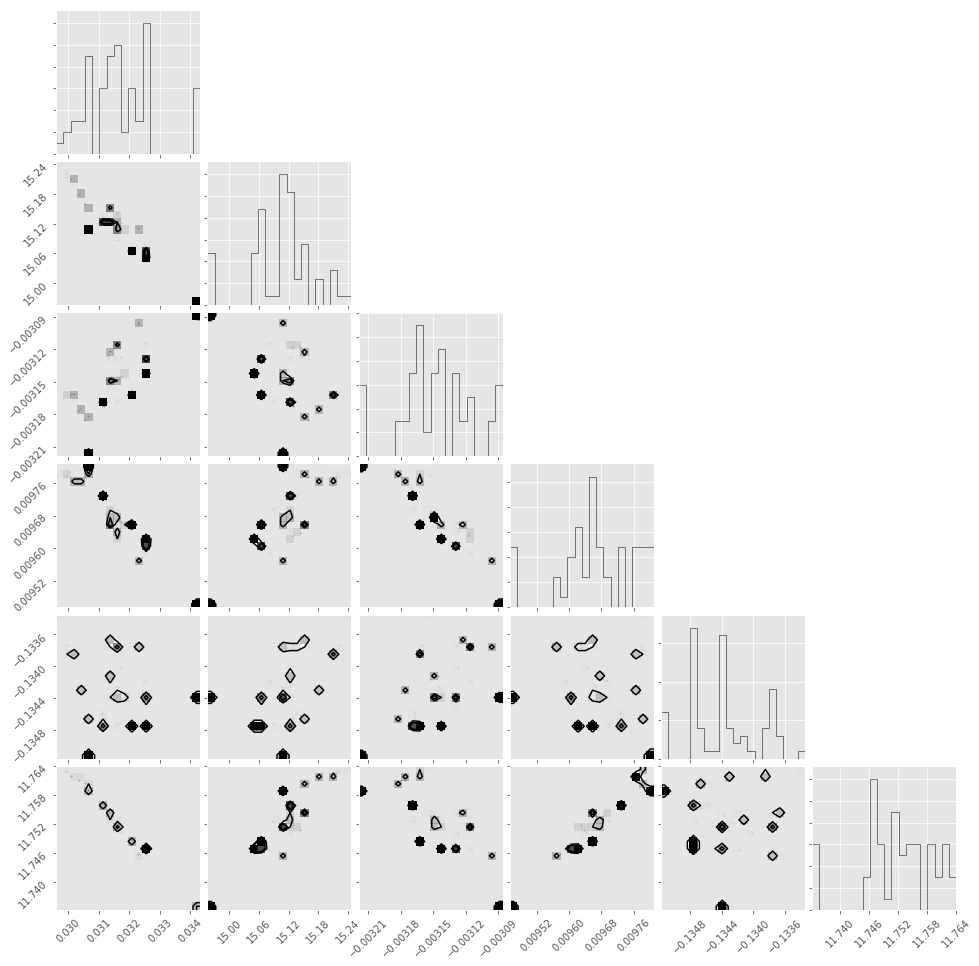

In [40]:
import corner
fig = corner.corner(samples)
fig.savefig("triangle.png")


In [41]:
mcmcphi2, mcmcdistance, mcmcpml, mcmcpmb, mcmcvr, mcmcm = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [42]:
print(mcmcphi2, mcmcdistance, mcmcpml, mcmcpmb, mcmcvr, mcmcm)

(0.031618444148694747, 0.00084227228998090542, 0.001039951310844691) (15.108608644537259, 0.046626360997640504, 0.050707142130899996) (-0.0031468245570670066, 2.9622137705375296e-05, 2.7771098868656537e-05) (0.0096647752500555045, 0.00010927221124465251, 6.0312693447276897e-05) (-0.13440648218001197, 0.00062445976051028751, 0.00035246825714183028) (11.751909562313237, 0.0077231599701725884, 0.0049931916909429219)


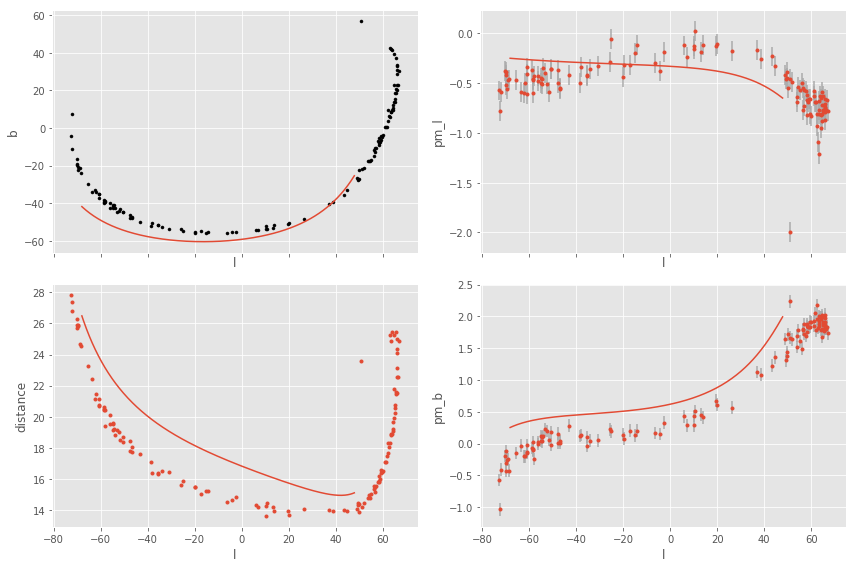

In [43]:
pfinal = [f[0] for f in [mcmcphi2, mcmcdistance, mcmcpml, mcmcpmb, mcmcvr, mcmcm]]
fig,axes = plot_mcmc_sample_orbit(pfinal)